# Correcting Outflow Data for Diffused Air and Evaportaion

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
def sample_pts2(points, max_time_step, max_points):

    '''This function samples points form the outflow data. 
    It samples less points where the plot of the data is flat and more points where the 
    plot of the data is curved. Points are selected based on a time step and a mass step.'''
    
    # Prealocating list to store data selected data points in.
    chosen = []

    # Specifying the starting place for point to point comparison (point 'a' to point 'b').
    # Also adding the first point (point a) to the prealocated list 'chosen'.
    a = np.min(points)
    b = a + 1
    chosen.append(a)
    
    # Creates short-hand variables for a shorter code. The lond had names are used in the definition line to provide more clear explanation.
    mx_ts = max_time_step
    mx_ps = max_points

    # Finds the max and minimum in the list of points.
    top = np.max(points)
    bottom = np.min(points)

    # For loop to exicute point to point comparison while changing the step distances to accomodate for curviture of the plot and sampling rates of the data.
    for count in range(len(points)):
        if (df.Delta_sec[b] - df.Delta_sec[a]) <= mx_ts or (df['Mass (g)'][b] - df['Mass (g)'][a]) < (df['Mass (g)'][top] - df['Mass (g)'][bottom]) / mx_ps:
            b = b + 1   # Increases the step by an incrament of 1 (one) to when the time step or mass step are smaller than desired.
        else:
            chosen.append(b)   # Collects the desired points.
            a = b              # Resetting the first point of comparison to the previously found desired point.
            b = b + 1          # Stepping forwar one point to initiate the process of selecting the next desired point.
    
    # Returning a dataframe of the selected points.
    return(pd.DataFrame({'chosen_pts': chosen}))

Input the amount of air measured in the bubble trap, in mL: 11


The rate of diffused air is: 0.45 gr./gr.


Input the mass of water required to saturate the sampe, in gr.: 37
Input the mass of water imbibed into the sampe, in gr.: 37


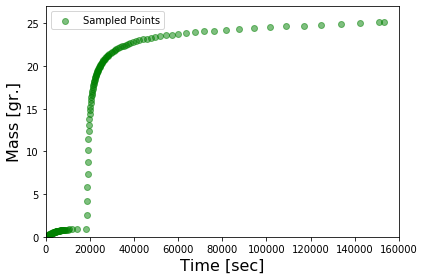

Sampled outflow data have been exported to the csv file titled TRIM_input.csv


In [30]:
### Reading raw evaporation data.
df = pd.read_csv('..\AGRON 935\Valley_Sub_raw.csv', sep = '\t')

#........................................................................................................................

# Defining the dataframe of interest to be used for calculaitng the evaporation rate.

## Excludes the NAN's at the very end of the dataframe.
start = 0
end = len(df)-1    
df = df[start:end]

## Giving a meaningful names to a column of data.
df['Mass'] = df['Unnamed: 3']
df['Uair (kPa)'] = df['Step']
df['Step'] = df['Time']
df['Time'] = df['Unnamed: 1']
df = df.drop(columns=['Unnamed: 1','Unnamed: 3','Unnamed: 5','Notes'])

## Converting time from [[YYYY/MM/DD], [HH:MM AM/PM]] to [sec] for calculations and plotting.
df['Datetime'] = pd.to_datetime(df.Date + " " + df.Time)                  # from [[MM/DD/YYYY], [HH:MM, AM/PM]] to [YYYY/MM/DD, HH:MM:SS].
df['Time_diff']= df.Datetime - df.Datetime[start]                         # from [YYYY/MM/DD, HH:MM:SS] to [days, HH:MM:SS].
df['Delta_sec']= df.Time_diff.dt.days * 86400 + df.Time_diff.dt.seconds   # from [days, HH:MM:SS] to [sec].

#........................................................................................................................

# Sort data into 'Before Test', 'small increment', and 'Large increment' lists via indexes.

## Removing 'Before Test' data.
idx = df.Step != 'Before Test'      # Identifies the rows to keep: 'small' and 'Large increments' which are not 'Before Test'.
df = df[idx]                        # Applies the index to the dataframe removing the 'Before Test' data.
df = df.reset_index(0)              # Resets the index to zero.
df = df.drop(columns = ['index'])   # Drops the old index column.

## Preallocate lists to store appropriate index values.
sm_inc_idx = []
lg_inc_idx = []

## Using a for loop to sort index values based on step: 'samll increment' and 'Large increment'.
for index in range(len(df.Step)):    
    if df.Step[index] == 'small increment':
        sm_inc_idx.append(index)
    else:
        lg_inc_idx.append(index)

#........................................................................................................................

# Calculating the rate of diffused air, and correcting the large increment data for diffused air.

## User input Bubble Trap measurement, in mL.
bub_trap = float(input("Input the amount of air measured in the bubble trap, in mL:"))   # [mL]

## Calculate the mass of water released during the Large increment, in grams. 
H2O_lg_inc = df.Mass[np.max(lg_inc_idx)] - df.Mass[np.min(lg_inc_idx)]   #[gr.]

## Calculate the rate of diffused air during the Large increment.
rt_diff_air = bub_trap / H2O_lg_inc   #[ml H2O displaced / grams large increment H2O outflow] = [gr./gr.], when rho_H2O=1.0 gr/ml
print('The rate of diffused air is:', round(rt_diff_air,2), 'gr./gr.')

## Create an array of large increment mass values for element-wise corrections.
lg_inc_array = np.array(df.Mass)

## Prealocate a temporary list to store corrected mass values.
Corrected_masses = []

## Using a for loop for elementwise correction of the large increment; the for loop is indexed to apply the correction to the large increment data only.
## Equation: Correct_Mass1[gr.] = Mass1[gr.] - (Mass1[gr.] - Mass0[gr.]) * Rate_diff_air[ml/gr.]
for index in range(np.min(lg_inc_idx),np.max(lg_inc_idx)):
    new_mass = lg_inc_array[index] - (lg_inc_array[index] - lg_inc_array[index-1]) * rt_diff_air
    Corrected_masses.append([new_mass])

#........................................................................................................................

# Replacing the old large increment masses with those corrected for diffused air.

## Create a second dataframe of corrected large increment masses.
df2 = pd.DataFrame(Corrected_masses)
df2['Mass'] = df2                                   #[gr.]

## Using a for loop to replace the old large increment masses in the 
## original dataframe with the new/corrected masses in the second dataframe.
for index in range(np.min(lg_inc_idx), np.max(lg_inc_idx)):
    index2 = index - np.min(lg_inc_idx)
    old_mass = df.Mass[index]                       #[gr.]
    new_mass = df2.Mass[index2]                     #[gr.]
    df.Mass = df.Mass.replace(old_mass, new_mass)   #[gr.]

#........................................................................................................................   

# Correcting all mass measurements for evaportion and for oversaturation.

## User inputs the mass of water required to saturate the sample and the amount that was in the sample when the test was initiated.
required_water = float(input("Input the mass of water required to saturate the sampe, in gr.:"))   # [gr.]
imbibed_water = float(input("Input the mass of water imbibed into the sampe, in gr.:"))            # [gr.]

## Equaiton: Correct_Mass1[gr.] = Mass1[gr.] + Comulative_time[sec] * Evap_rate[gr./sec]
evap_rate = 0.0927/86400                                      #[gr./sec], Evaporation rate is constant.
excess_water = imbibed_water - required_water                 #[gr.]
df.Mass = df.Mass + df.Delta_sec * evap_rate - excess_water   #[gr.]

## Updataing the 'Mass (g)' column with the corrected 'Mass' values, and removing the rows with negative mass values.
df['Mass (g)'] = df.Mass
df = df.drop(columns = ['Mass'])
idx = df['Mass (g)'] > 0                                     # Developing a boolian index to excluded negative mass values.
df = df[idx]                                                 # selecting range of rows in the dataframe that have positive mass values.
df = df.reset_index(0)                                       # Resetting the index to start with zero.
df = df.drop(columns = ['index', 'Datetime', 'Time_diff'])   # Removing un-needed columns of transitional information.

#........................................................................................................................

# Redefine the 'small increment', and 'Large increment' indexes.

## Preallocate lists to store appropriate index values.
sm_inc_idx = []
lg_inc_idx = []

## Using a for loop to sort index values based on step: 'samll increment' and 'Large increment'.
for index in range(len(df.Step)):    
    if df.Step[index] == 'small increment':
        sm_inc_idx.append(index)
    else:
        lg_inc_idx.append(index)
        
#........................................................................................................................

# Sampling data from the corrected TRIM data.

## Specifying the step size for time and mass.
mx_ts = 300   # Should not exceed the max sampling rate used to collect the TRIM experiment data, typically 300 seconds.
mx_ps = 100   # Should not be less than the minimum number of points recommended for inverse modeling procedures: 100 points, (Wayllace and Lu 2012).

## Exicuting the sampling function for the small and the large step incraments of the TRIM test individually, then combining the two dataframes into one.
chosen_sm = sample_pts2(range(np.min(sm_inc_idx),np.max(sm_inc_idx)),mx_ts,mx_ps)
chosen_lg = sample_pts2(range(np.min(lg_inc_idx),np.max(lg_inc_idx)),mx_ts,mx_ps)
df3 = chosen_sm.append(chosen_lg)

## Optimizing the step size to meet or slightly exceed the minium number of points for modeling. The minimum number of point required is 100.
while len(df3) < 150:
    
    df3 = []   # Emptying the dataframe
    
    ## Adjusting the step sizes
    mx_ts = mx_ts - 25
    mx_ps = mx_ps + 25
    
    ## Re-exicuting the sampling fucntion with the adjusted step sizes and merging the two dataframes into one.
    chosen_sm = sample_pts2(range(np.min(sm_inc_idx),np.max(sm_inc_idx)),mx_ts,mx_ps)
    chosen_lg = sample_pts2(range(np.min(lg_inc_idx),np.max(lg_inc_idx)),mx_ts,mx_ps)
    df3 = chosen_sm.append(chosen_lg)

#........................................................................................................................ 

# Plotting the selected points to show the sampled data.
plt.scatter(df.Delta_sec.reindex(df3.chosen_pts), df['Mass (g)'].reindex(df3.chosen_pts), alpha = 0.5, label='Sampled Points', color = 'green')
plt.ylabel('Mass [gr.]', fontsize = 16)
plt.xlabel('Time [sec]', fontsize = 16)
plt.xlim(0, 160000)
plt.ylim(0, 27)
plt.legend()
plt.tight_layout()
plt.show()

#........................................................................................................................ 

# Exporting the sampled points as .csv file: TRIM_input.csv.

## Create a dataframe to store all the information that are to be exported.
TRIM_input = pd.DataFrame()

## Add all the appropriate data to that dataframe: data are selected using the sampled points 
## as an index so that the corresponding data for each selected point is collected.
TRIM_input['Date'] = df.Date[df3.chosen_pts]
TRIM_input['Time'] = df.Time[df3.chosen_pts]
TRIM_input['Step'] = df.Step[df3.chosen_pts]
TRIM_input['Mass (g)'] = df['Mass (g)'].reindex(df3.chosen_pts)
TRIM_input['Uair (kPa)'] = df['Uair (kPa)'].reindex(df3.chosen_pts)

## Sets the 'Date' column as the dataframe index.
TRIM_input = TRIM_input.set_index('Date')

## Create a csv file for the dataframe to be passed to and stored in.
TRIM_input.to_csv('TRIM_input.csv', sep = '\t')
print(' ')
print('Sampled outflow data have been exported to the csv file: TRIM_input.csv')

In [31]:
# Read the csv file to check for mistakes.
pd.read_csv('TRIM_input.csv', sep = '\t')

,Date,Time,Step,Mass (g),Uair (kPa)
0,7/24/2019,9:19:52 AM,small increment,0.000032,3.0
1,7/24/2019,9:22:02 AM,small increment,0.030172,4.0
2,7/24/2019,9:24:12 AM,small increment,0.050311,4.0
3,7/24/2019,9:26:23 AM,small increment,0.070452,4.0
4,7/24/2019,9:28:33 AM,small increment,0.100591,4.0
...,...,...,...,...,...
151,7/25/2019,8:01:28 PM,Large increment,24.844035,290.0
152,7/25/2019,10:31:31 PM,Large increment,24.933695,290.0
153,7/26/2019,12:51:34 AM,Large increment,25.022710,290.0
154,7/26/2019,3:16:37 AM,Large increment,25.117508,290.0


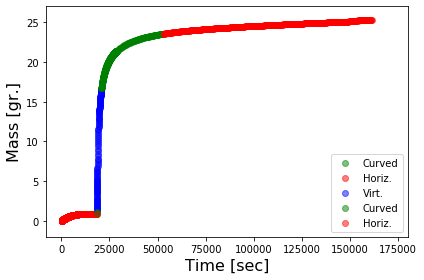

In [5]:
#Pot figure of Raw TRIM Data to check it out.
#plt.figure(figsize = (8,8))
#plt.subplot(2,2,1)
#plt.scatter(df['Delta_sec'][lg_vert], df['Mass (g)'][lg_vert], alpha = 0.5, label='Obs. Transient Outflow', color = 'blue')
#plt.xlim(-8000, 180000)
#plt.ylim(-2, 27)
#plt.ylabel('Mass [gr.]', fontsize = 16)
#plt.xlabel('Time [sec]', fontsize = 16)
#plt.legend()

#plt.subplot(2,2,2)
#plt.scatter(df['Delta_sec'][sm_curved], df['Mass (g)'][sm_curved], alpha = 0.5, label='Obs. Transient Outflow', color = 'green')
#plt.scatter(df['Delta_sec'][lg_curved], df['Mass (g)'][lg_curved], alpha = 0.5, label='Obs. Transient Outflow', color = 'green')
#plt.xlim(-8000, 180000)
#plt.ylim(-2, 27)
#plt.ylabel('Mass [gr.]', fontsize = 16)
#plt.xlabel('Time [sec]', fontsize = 16)
#plt.legend()

#plt.subplot(2,2,3)
#plt.scatter(df['Delta_sec'][sm_horiz], df['Mass (g)'][sm_horiz], alpha = 0.5, label='Obs. Transient Outflow', color = 'red')
#plt.scatter(df['Delta_sec'][lg_horiz], df['Mass (g)'][lg_horiz], alpha = 0.5, label='Obs. Transient Outflow', color = 'red')
#plt.ylabel('Mass [gr.]', fontsize = 16)
#plt.xlabel('Time [sec]', fontsize = 16)
#plt.xlim(-8000, 180000)
#plt.ylim(-2, 27)
#plt.legend()
#plt.tight_layout()

#plt.subplot(2,2,4)
plt.scatter(df['Delta_sec'][sm_curved], df['Mass (g)'][sm_curved], alpha = 0.5, label='Curved', color = 'green')
plt.scatter(df['Delta_sec'][sm_horiz], df['Mass (g)'][sm_horiz], alpha = 0.5, label='Horiz.', color = 'red')
plt.scatter(df['Delta_sec'][lg_vert], df['Mass (g)'][lg_vert], alpha = 0.5, label='Virt.', color = 'blue')
plt.scatter(df['Delta_sec'][lg_curved], df['Mass (g)'][lg_curved], alpha = 0.5, label='Curved', color = 'green')
plt.scatter(df['Delta_sec'][lg_horiz], df['Mass (g)'][lg_horiz], alpha = 0.5, label='Horiz.', color = 'red')
plt.ylabel('Mass [gr.]', fontsize = 16)
plt.xlabel('Time [sec]', fontsize = 16)
plt.xlim(-8000, 180000)
plt.ylim(-2, 27)
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
def sample_pts(orig_pts):

    '''This code systematically selects ~50 points form a list using a fixed interval and returns a dataframe of the slected points. 
    Ex: 200 original points / 50 desired points = step of 4; every 4th point will be selected.'''
    
    chosen = []
    des_pts = 50
    x = orig_pts
    step = round(len(orig_pts)/des_pts)
    for i in range(len(orig_pts)):
        if (x[i]/step).is_integer():
            chosen.append(x[i])

    return(pd.DataFrame({'chosen_pts': chosen}))

In [21]:
#Select ~50 points from each part of the outflow curve using function sample_pts().
sp_0 = sample_pts(sm_curved)
sp_1 = sample_pts(sm_horiz)
sp_2 = sample_pts(lg_vert)
sp_3 = sample_pts(lg_curved)
sp_4 = sample_pts(lg_horiz)

#Merge each of the lists of sampled points into one long list.
df3 = sp_0.append(sp_1)
df3 = df3.append(sp_2)
df3 = df3.append(sp_3)
df3 = df3.append(sp_4)

#Collect the Masses and Times corresponding to the sampled points and store as 
Sampled_Mass = df['Mass (g)'].reindex(df3.chosen_pts)
Sampled_Time = df['Delta_sec'].reindex(df3.chosen_pts)

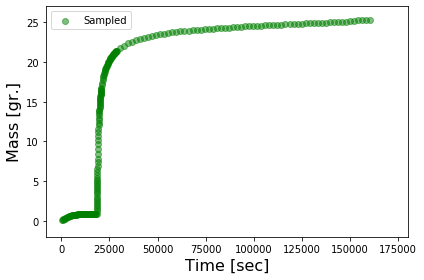

In [22]:
plt.scatter(Sampled_Time, Sampled_Mass, alpha = 0.5, label='Sampled', color = 'green')
plt.ylabel('Mass [gr.]', fontsize = 16)
plt.xlabel('Time [sec]', fontsize = 16)
plt.xlim(-8000, 180000)
plt.ylim(-2, 27)
plt.legend()
plt.tight_layout()
plt.show()